In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay

# Dataset

In [2]:
df_tab = pd.read_csv('mod_data_for_decision_tree.csv')
df_name = pd.read_csv('mod_data_name_end_only.csv')
df_summary = pd.read_csv('mod_data_summary_end_only.csv')
df_desc = pd.read_json('mod_data_desc_end_only.json')

Convert string to numbers for tabular data

In [3]:
df_tab['author'] = df_tab['author'].astype('category')
df_tab['uploaded_by'] = df_tab['uploaded_by'].astype('category')

cat_columns = df_tab.select_dtypes(['category']).columns
df_tab[cat_columns] = df_tab[cat_columns].apply(lambda x: x.cat.codes)

df_tab.head()

category_id  endorsement_count    created_time  author  uploaded_by  \
0           96                184  11:14:58+00:00     543          326   
1           96                196  11:14:58+00:00     543          326   
2            5               1295  11:14:58+00:00     543          326   
3           53               4545  11:39:31+00:00    1396          775   
4           94                108  00:52:40+00:00     322         6289   

   contains_adult_content  high  
0                       0     1  
1                       0     1  
2                       1     1  
3                       0     1  
4                       0     1

Treating outliers

In [4]:
def filter(df, max_endorsment):
    return df[(df['endorsement_count'] <= max_endorsment)]

indexes_to_keep = []
with open('mod_indexes.txt', 'r') as f:
    temp = f.readlines()
    for x in temp:
        indexes_to_keep.append(int(x))

### Tabular data
cat_counts = df_tab['category_id'].value_counts()
# Only accept mods from categories that have more than 300 entries
filtered_cat = cat_counts[cat_counts > 300]
safe_categories = filtered_cat.index.tolist()

df_tab_filtered = df_tab[df_tab['category_id'].isin(safe_categories)]
# Filter out mods with more than 1000 endorsements
df_tab_filtered = filter(df_tab_filtered, 1000)

### Name data
df_name_filtered = df_name[df_name.index.isin(indexes_to_keep)]
df_name_filtered = filter(df_name_filtered, 1000)

### Summary data
df_summary_filtered = df_summary[df_summary.index.isin(indexes_to_keep)]
df_summary_filtered = filter(df_summary_filtered, 1000)
df_summary_filtered.fillna('', inplace=True)

### Description data
df_desc_filtered = df_desc[df_desc.index.isin(indexes_to_keep)]
df_desc_filtered = filter(df_desc_filtered, 1000)
df_desc_filtered.fillna('', inplace=True)

print('Tabular')
print(df_tab_filtered['high'].value_counts())
print('-'*30)
print('Name')
print(df_name_filtered['high'].value_counts())
print('-'*30)
print('Summary')
print(df_summary_filtered['high'].value_counts())
print('-'*30)
print('Description')
print(df_desc_filtered['high'].value_counts())

Tabular
0    14206
1     9282
Name: high, dtype: int64
------------------------------
Name
0    14206
1     7230
Name: high, dtype: int64
------------------------------
Summary
0    14206
1     7230
Name: high, dtype: int64
------------------------------
Description
0    6328
1    5319
Name: high, dtype: int64


Balancing the dataset

In [5]:
from dataset_preprocessor import perform_undersampling, perform_oversampling

df_tab_balanced = perform_oversampling(df_tab_filtered)
df_name_balanced = perform_oversampling(df_name_filtered)
df_summary_balanced = perform_oversampling(df_summary_filtered)
df_desc_balanced = perform_oversampling(df_desc_filtered)

print('Tabular')
print(df_tab_balanced['high'].value_counts())
print('-'*30)
print('Name')
print(df_name_balanced['high'].value_counts())
print('-'*30)
print('Summary')
print(df_summary_balanced['high'].value_counts())
print('-'*30)
print('Description')
print(df_desc_balanced['high'].value_counts())

Tabular
0    14206
1    14206
Name: high, dtype: int64
------------------------------
Name
0    14206
1    14206
Name: high, dtype: int64
------------------------------
Summary
0    14206
1    14206
Name: high, dtype: int64
------------------------------
Description
0    6328
1    6328
Name: high, dtype: int64


# Training

## Load pretrained models

In [6]:
xgb_model = xgb.XGBClassifier()
xgb_model.load_model('model_checkpoints/xgb/xgb_model.txt')

In [7]:
preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
encoder_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

In [8]:
bert_preprocess = hub.KerasLayer(preprocess_url)
bert_encoder = hub.KerasLayer(encoder_url)

def create_summary_model(bert_preprocess, bert_encoder):
    # Bert layers
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)

    # Neural Network layers
    l = tf.keras.layers.Dropout(0.1, name='dropout') (outputs['pooled_output'])
    l = tf.keras.layers.Dense(128, activation='relu') (l)
    # l = tf.keras.layers.Dropout(0.1, name='dropout2') (l)
    l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

    # Construct final model
    return tf.keras.Model(inputs=[text_input], outputs=[l])

def create_name_model(bert_preprocess, bert_encoder):
    # Bert layers
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)

    # Neural Network layers
    l = tf.keras.layers.Dropout(0.1, name='dropout') (outputs['pooled_output'])
    l = tf.keras.layers.Dense(128, activation='relu') (l)
    # l = tf.keras.layers.Dropout(0.1, name='dropout2') (l)
    l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

    # Construct final model
    return tf.keras.Model(inputs=[text_input], outputs=[l])

def create_desc_model(bert_preprocess, bert_encoder):
    # Bert layers
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)

    # Neural Network layers
    l = tf.keras.layers.Dropout(0.1, name='dropout') (outputs['pooled_output'])
    l = tf.keras.layers.Dense(128, activation='relu') (l)
    # l = tf.keras.layers.Dropout(0.1, name='dropout2') (l)
    l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

    # Construct final model
    return tf.keras.Model(inputs=[text_input], outputs=[l])

# Construct final model
name_model = create_name_model(bert_preprocess, bert_encoder)
summary_model = create_summary_model(bert_preprocess, bert_encoder)
desc_model = create_desc_model(bert_preprocess, bert_encoder)

# Load weights
name_model.load_weights('model_checkpoints/name_bert_model/')
summary_model.load_weights('model_checkpoints/summary_bert_model/')
desc_model.load_weights('model_checkpoints/desc_bert_model/')

name_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

## Build ensembled dataset

Get output from XGBoost

In [9]:
df_tab_main = df_tab_balanced

y = df_tab_main['high']
x_tab = df_tab_main.drop(['high', 'endorsement_count', 'created_time'], axis=1)

output_tab = xgb_model.predict_proba(x_tab)

output_tab

array([[0.9514732 , 0.04852684],
       [0.9896425 , 0.01035747],
       [0.9896425 , 0.01035747],
       ...,
       [0.06331658, 0.9366834 ],
       [0.02972829, 0.9702717 ],
       [0.15646374, 0.84353626]], dtype=float32)

Get output from names RNN

In [10]:
df_name_main = df_name_balanced

y_name = df_name_main['high']
x_name = df_name_main.drop(['high', 'endorsement_count'], axis=1)

output_name = name_model.predict(x_name).flatten()

In [11]:
output_name

array([0.3415675 , 0.5842038 , 0.55210507, ..., 0.5094242 , 0.15016168,
       0.6052314 ], dtype=float32)

Get output from summary RNN

In [12]:
df_summary_main = df_summary_balanced

y_summary = df_summary_main['high']
x_summary = df_summary_main.drop(['high', 'endorsement_count'], axis=1)

output_summary = summary_model.predict(x_summary).flatten()

In [13]:
output_summary

array([0.17117858, 0.48727795, 0.60331494, ..., 0.6615587 , 0.6157694 ,
       0.7718302 ], dtype=float32)

Get output from description RNN

In [14]:
df_desc_main = df_desc_balanced

y_desc = df_desc_main['high']
x_desc = df_desc_main.drop(['high', 'endorsement_count'], axis=1)

output_desc = desc_model.predict(x_desc).flatten()

In [15]:
output_desc

array([0.13592698, 0.39408323, 0.48774347, ..., 0.47505966, 0.4656965 ,
       0.5733304 ], dtype=float32)

Merge the outputs into one DataFrame

In [16]:
df = pd.DataFrame()

# Manage description
df_temp = pd.DataFrame()
df_temp['output'] = output_desc
df_temp.index = df_desc_main.index

# df['xgb_1'] = [x[0] for x in output_tab]
df['xgb_2'] = [x[1] for x in output_tab]
df['name'] = output_name
df['summary'] = output_summary
df['desc'] = [-1.2 for _ in range(df.shape[0])]     # -1.2 to represent NaN (to keep the dtype of this column as float and not object)
y = df_tab_main['high']
df['high'] = y.tolist()

# Insert description output to the merged dataframe
for index, row in df_temp.iterrows():
    df.at[index, 'desc'] = row['output']

# Remove rows with empty desc data
df.dropna(inplace=True)

# Convert desc column into number
df.astype({'desc' : 'float64'})

df.drop(df[df['desc'] == -1.2].index, inplace=True)
print(df.shape)
print(df['high'].value_counts())
# df.drop(['desc'], axis=1, inplace=True)
df.head()

(9363, 5)
1.0    5716
0.0    3647
Name: high, dtype: int64


xgb_2      name   summary      desc  high
23   0.566987  0.524953  0.579995  0.570417   0.0
24   0.566987  0.448753  0.557634  0.641750   0.0
84   0.243285  0.333934  0.237955  0.135927   0.0
114  0.020674  0.584881  0.573539  0.394083   0.0
116  0.494271  0.437396  0.537746  0.487743   0.0

Balance the dataset

In [17]:
def perform_oversampling(df):
    df_high = df[df['high'] == 1]
    df_low = df[df['high'] == 0]
    df_low_oversampled = df_low.sample(df_high.shape[0], replace=True)
    return pd.concat([df_low_oversampled, df_high], axis=0)

df_balanced = perform_oversampling(df)
df_balanced['high'].value_counts()

0.0    5716
1.0    5716
Name: high, dtype: int64

Train-test split

In [18]:
seed = 69420
# seed = 15003

y = df_balanced['high']
x = df_balanced.drop(['high'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=df_balanced['high'], random_state=seed)

# Ensembled Training

Create model

In [19]:
model = xgb.XGBClassifier(
    eval_metric='auc',
    subsample = 0.5,
    n_estimators=800,
    max_depth=500,
    colsample_bytree=0.5,
    learning_rate=0.11,
    use_label_encoder=False
)

eval_set = [(x_train, y_train), (x_test, y_test)]

Train

In [20]:
model.fit(
    x_train,
    y_train,
    early_stopping_rounds=10,
    eval_set=eval_set,
    verbose=True,
)

[0]	validation_0-auc:0.93338	validation_1-auc:0.93961
[1]	validation_0-auc:0.93918	validation_1-auc:0.94216
[2]	validation_0-auc:0.94931	validation_1-auc:0.94926
[3]	validation_0-auc:0.95247	validation_1-auc:0.95183
[4]	validation_0-auc:0.95911	validation_1-auc:0.95591
[5]	validation_0-auc:0.96925	validation_1-auc:0.95902
[6]	validation_0-auc:0.97454	validation_1-auc:0.96004
[7]	validation_0-auc:0.97901	validation_1-auc:0.96103
[8]	validation_0-auc:0.97891	validation_1-auc:0.96089
[9]	validation_0-auc:0.97852	validation_1-auc:0.96118
[10]	validation_0-auc:0.98146	validation_1-auc:0.96238
[11]	validation_0-auc:0.98057	validation_1-auc:0.96264
[12]	validation_0-auc:0.98324	validation_1-auc:0.96422
[13]	validation_0-auc:0.98344	validation_1-auc:0.96473
[14]	validation_0-auc:0.98534	validation_1-auc:0.96466
[15]	validation_0-auc:0.98530	validation_1-auc:0.96508
[16]	validation_0-auc:0.98569	validation_1-auc:0.96576
[17]	validation_0-auc:0.98701	validation_1-auc:0.96579
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.11, max_delta_step=0, max_depth=500,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=800, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.5, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

## Evaluation

In [21]:
y_true = np.array(y_test.tolist())
y_pred = model.predict_proba(x_test)[:,1]
y_pred = np.where(y_pred > 0.5, 1, 0)   # Change values into 1s or 0s

y_pred

array([0, 1, 1, ..., 1, 1, 1])

Text(33.0, 0.5, 'Truth')

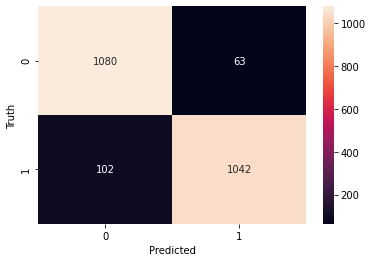

In [22]:
cm = confusion_matrix(y_true, y_pred)

sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [23]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93      1143
         1.0       0.94      0.91      0.93      1144

    accuracy                           0.93      2287
   macro avg       0.93      0.93      0.93      2287
weighted avg       0.93      0.93      0.93      2287



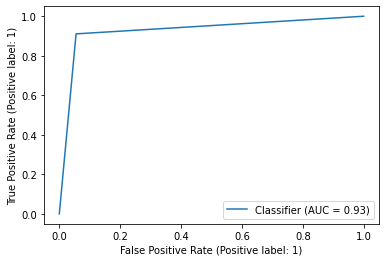

In [24]:
RocCurveDisplay.from_predictions(y_true, y_pred)

See variable importance

In [25]:
columns = [c for c in x.columns]

df_var_imp = pd.DataFrame({"Variable": columns,
                           "Importance": model.feature_importances_}) \
                        .sort_values(by='Importance', ascending=False)
df_var_imp[:10]

Variable  Importance
0    xgb_2    0.617784
2  summary    0.133879
1     name    0.131725
3     desc    0.116612

Save the model

In [26]:
# model.save_model('model_checkpoints/xgb/xgb_ensembled.txt')